In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns

from datetime import timedelta
from scipy.stats import ttest_ind

from preprocess_and_exploration import data_folder

# Data Preprocess

## Load Dataset

In [2]:
audible_data = pd.read_csv(data_folder + '/audible_uncleaned.csv')
audible_data.head()

,name,author,narrator,time,releasedate,language,stars,price
0,Geronimo Stilton #11 & #12,Writtenby:GeronimoStilton,Narratedby:BillLobely,2 hrs and 20 mins,04-08-08,English,5 out of 5 stars34 ratings,468.00
1,The Burning Maze,Writtenby:RickRiordan,Narratedby:RobbieDaymond,13 hrs and 8 mins,01-05-18,English,4.5 out of 5 stars41 ratings,820.00
2,The Deep End,Writtenby:JeffKinney,Narratedby:DanRussell,2 hrs and 3 mins,06-11-20,English,4.5 out of 5 stars38 ratings,410.00
3,Daughter of the Deep,Writtenby:RickRiordan,Narratedby:SoneelaNankani,11 hrs and 16 mins,05-10-21,English,4.5 out of 5 stars12 ratings,615.00
4,"The Lightning Thief: Percy Jackson, Book 1",Writtenby:RickRiordan,Narratedby:JesseBernstein,10 hrs,13-01-10,English,4.5 out of 5 stars181 ratings,820.00


In [3]:
audible_data.rename(columns={'releasedate': 'release date'}, inplace=True)
audible_data.rename(str.title, axis='columns', inplace=True)
audible_data.head()

,Name,Author,Narrator,Time,Release Date,Language,Stars,Price
0,Geronimo Stilton #11 & #12,Writtenby:GeronimoStilton,Narratedby:BillLobely,2 hrs and 20 mins,04-08-08,English,5 out of 5 stars34 ratings,468.00
1,The Burning Maze,Writtenby:RickRiordan,Narratedby:RobbieDaymond,13 hrs and 8 mins,01-05-18,English,4.5 out of 5 stars41 ratings,820.00
2,The Deep End,Writtenby:JeffKinney,Narratedby:DanRussell,2 hrs and 3 mins,06-11-20,English,4.5 out of 5 stars38 ratings,410.00
3,Daughter of the Deep,Writtenby:RickRiordan,Narratedby:SoneelaNankani,11 hrs and 16 mins,05-10-21,English,4.5 out of 5 stars12 ratings,615.00
4,"The Lightning Thief: Percy Jackson, Book 1",Writtenby:RickRiordan,Narratedby:JesseBernstein,10 hrs,13-01-10,English,4.5 out of 5 stars181 ratings,820.00


In [4]:
audible_data.describe(include='all')

,Name,Author,Narrator,Time,Release Date,Language,Stars,Price
count,87489,87489,87489,87489,87489,87489,87489,87489
unique,82767,48374,29717,2284,5058,36,665,1011
top,The Art of War,"Writtenby:矢島雅弘,石橋遊",Narratedby:anonymous,2 mins,16-05-18,English,Not rated yet,586.00
freq,20,874,1034,372,773,61884,72417,5533


In [5]:
audible_data.dtypes

Name            object
Author          object
Narrator        object
Time            object
Release Date    object
Language        object
Stars           object
Price           object
dtype: object

## Author Column Preprocess

### Strip "Writtenby:"

In [6]:
audible_data['Author'] = audible_data['Author'].str.replace('Writtenby:', '')
audible_data['Author'].head()

0    GeronimoStilton
1        RickRiordan
2         JeffKinney
3        RickRiordan
4        RickRiordan
Name: Author, dtype: object

### Handle Multiple Authors

In [7]:
audible_data['Author'] = audible_data['Author'].str.rstrip(',').str.split(',')
audible_data.loc[audible_data['Author'].apply(len) > 1, 'Author'].head()

53                    [JuliaDonaldson, AxelScheffler]
72                             [Vegetta777, Willyrex]
74        [SophieSchoenwald, NadineReitz-Illustrator]
77     [BertrandFichou, NoraThullin, CatherinedeLasa]
101                         [M.G.Leonard, SamSedgman]
Name: Author, dtype: object

## Narrator Column Preprocess

### Strip "Narratedby:"

In [8]:
audible_data['Narrator'] = audible_data['Narrator'].str.replace('Narratedby:', '')
audible_data['Narrator'].head()

0        BillLobely
1     RobbieDaymond
2        DanRussell
3    SoneelaNankani
4    JesseBernstein
Name: Narrator, dtype: object

### Handle Multiple Narrators

In [9]:
audible_data['Narrator'] = audible_data['Narrator'].str.rstrip(',').str.split(',')
audible_data.loc[audible_data['Narrator'].apply(len) > 1, 'Narrator'].head()

14          [PhilipPullman, fullcast, RuthWilson]
28                   [JaneCollingwood, JosephMay]
34    [MonicaRachelle, JimD.Johnston, KatieOtten]
58     [LenForgione, AshtonSundholm, JadenRogers]
77    [GuyChappelier, FrédéricSanchez, MarieZidi]
Name: Narrator, dtype: object

## Time Column Preprocess

### Convert Time To Timedelta

In [10]:
def convert_to_timedelta(time_string):
    hours_match = re.search(r'(\d+)\s*hrs', time_string)
    minutes_match = re.search(r'(\d+)\s*mins', time_string)
    return timedelta(
        hours=int(hours_match.group(1)) if hours_match else 0,
        minutes=int(minutes_match.group(1)) if minutes_match else 0
    )

audible_data['Time'] = audible_data['Time'].apply(convert_to_timedelta)
audible_data['Time'].head()

0   0 days 02:20:00
1   0 days 13:08:00
2   0 days 02:03:00
3   0 days 11:16:00
4   0 days 10:00:00
Name: Time, dtype: timedelta64[ns]

## Release Date Column Preprocess

### Convert Release Date To Datetime

In [11]:
audible_data['Release Date'] = pd.to_datetime(audible_data['Release Date'], format='%d-%m-%y')
audible_data['Release Date'].head()

0   2008-08-04
1   2018-05-01
2   2020-11-06
3   2021-10-05
4   2010-01-13
Name: Release Date, dtype: datetime64[ns]

## Language Column Preprocess

In [12]:
audible_data['Language'] = audible_data['Language'].str.title()
audible_data['Language'].value_counts()

Language
English             61884
German               8295
Spanish              3496
Japanese             3167
Italian              2694
French               2386
Russian              1804
Danish                935
Portuguese            526
Swedish               515
Hindi                 436
Polish                224
Finnish               197
Dutch                 190
Tamil                 161
Catalan               153
Mandarin_Chinese       97
Icelandic              52
Romanian               50
Hungarian              36
Urdu                   34
Afrikaans              28
Czech                  23
Turkish                20
Greek                  18
Arabic                 16
Norwegian              16
Galician               10
Bulgarian               9
Korean                  4
Slovene                 4
Hebrew                  2
Basque                  2
Telugu                  2
Lithuanian              2
Ukrainian               1
Name: count, dtype: int64

## Stars Column Preprocess

### Examine Rated Or Not

In [13]:
audible_data['Rated'] = ~audible_data['Stars'].str.contains('Not rated yet')

In [14]:
audible_data.loc[audible_data['Rated'] == True, ['Rated', 'Stars']].head()

,Rated,Stars
0,True,5 out of 5 stars34 ratings
1,True,4.5 out of 5 stars41 ratings
2,True,4.5 out of 5 stars38 ratings
3,True,4.5 out of 5 stars12 ratings
4,True,4.5 out of 5 stars181 ratings


In [15]:
audible_data.loc[audible_data['Rated'] == False, ['Rated', 'Stars']].head()

,Rated,Stars
34,False,Not rated yet
50,False,Not rated yet
51,False,Not rated yet
61,False,Not rated yet
62,False,Not rated yet


### Extract Rating From Stars

In [16]:
audible_data['Stars'] = audible_data['Stars'].str.replace(',', '')
extract = lambda cast, row, regex, group_num : cast(re.search(regex, row['Stars']).group(group_num)) if row['Rated'] else np.nan
audible_data['Number Of Rating Response'] = audible_data.apply(lambda row: extract(int, row, r'stars(\d+) rating', 1), axis=1).astype('Int64')
audible_data['Stars'] = audible_data.apply(lambda row: extract(float, row, r'(\d+(\.\d+)?) out of', 1), axis=1).astype('Float64')
audible_data = audible_data[list(audible_data.columns)[:-4] + ['Rated', 'Stars', 'Number Of Rating Response', 'Price']]
audible_data.rename(columns={'Stars': 'Stars (Max: 5)'}, inplace=True)

In [17]:
audible_data.loc[audible_data['Rated'] == True, ['Rated', 'Stars (Max: 5)', 'Number Of Rating Response']].head()

,Rated,Stars (Max: 5),Number Of Rating Response
0,True,5.0,34
1,True,4.5,41
2,True,4.5,38
3,True,4.5,12
4,True,4.5,181


In [18]:
audible_data.loc[audible_data['Rated'] == False, ['Rated', 'Stars (Max: 5)', 'Number Of Rating Response']].head()

,Rated,Stars (Max: 5),Number Of Rating Response
34,False,<NA>,<NA>
50,False,<NA>,<NA>
51,False,<NA>,<NA>
61,False,<NA>,<NA>
62,False,<NA>,<NA>


## Price Column Preprocess

### Convert Price to Float

In [19]:
audible_data['Price'] = audible_data['Price'].str.replace('Free', '0').str.replace(',', '').astype('Float64')
audible_data['Price'].dtypes

Float64Dtype()

## Save Preprocessed Dataset

In [20]:
audible_data.to_csv(data_folder + '/audible.csv', index=False)

# Data Exploration 

In [21]:
audible_data.head()

,Name,Author,Narrator,Time,Release Date,Language,Rated,Stars (Max: 5),Number Of Rating Response,Price
0,Geronimo Stilton #11 & #12,[GeronimoStilton],[BillLobely],0 days 02:20:00,2008-08-04,English,True,5.0,34,468.0
1,The Burning Maze,[RickRiordan],[RobbieDaymond],0 days 13:08:00,2018-05-01,English,True,4.5,41,820.0
2,The Deep End,[JeffKinney],[DanRussell],0 days 02:03:00,2020-11-06,English,True,4.5,38,410.0
3,Daughter of the Deep,[RickRiordan],[SoneelaNankani],0 days 11:16:00,2021-10-05,English,True,4.5,12,615.0
4,"The Lightning Thief: Percy Jackson, Book 1",[RickRiordan],[JesseBernstein],0 days 10:00:00,2010-01-13,English,True,4.5,181,820.0


In [22]:
audible_data.describe(include='all')

,Name,Author,Narrator,Time,Release Date,Language,Rated,Stars (Max: 5),Number Of Rating Response,Price
count,87489,87489,87489,87489,87489,87489,87489,15072.0,15072.0,87489.0
unique,82767,48369,29703,NaN,NaN,36,2,<NA>,<NA>,<NA>
top,The Art of War,"[矢島雅弘, 石橋遊]",[anonymous],NaN,NaN,English,False,<NA>,<NA>,<NA>
freq,20,874,1034,NaN,NaN,61884,72417,<NA>,<NA>,<NA>
mean,NaN,NaN,NaN,0 days 06:52:51.884236875,2018-06-23 22:53:20.411480064,NaN,NaN,4.45694,21.61319,559.009246
min,NaN,NaN,NaN,0 days 00:00:00,1998-12-27 00:00:00,NaN,NaN,1.0,1.0,0.0
25%,NaN,NaN,NaN,0 days 02:22:00,2016-09-06 00:00:00,NaN,NaN,4.0,1.0,268.0
50%,NaN,NaN,NaN,0 days 06:26:00,2020-02-06 00:00:00,NaN,NaN,4.5,2.0,585.0
75%,NaN,NaN,NaN,0 days 09:44:00,2021-08-17 00:00:00,NaN,NaN,5.0,7.0,755.0
max,NaN,NaN,NaN,5 days 23:15:00,2025-11-14 00:00:00,NaN,NaN,5.0,12573.0,7198.0


In [23]:
audible_data.dtypes

Name                                  object
Author                                object
Narrator                              object
Time                         timedelta64[ns]
Release Date                  datetime64[ns]
Language                              object
Rated                                   bool
Stars (Max: 5)                       Float64
Number Of Rating Response              Int64
Price                                Float64
dtype: object

## Dataset Characteristics

### Features and Entries

In [24]:
audible_data.shape

(87489, 10)

### Rated vs. Not Rated

In [25]:
(audible_data['Rated'].sum(), (~audible_data['Rated']).sum())

(15072, 72417)

### Audiobook Lengths

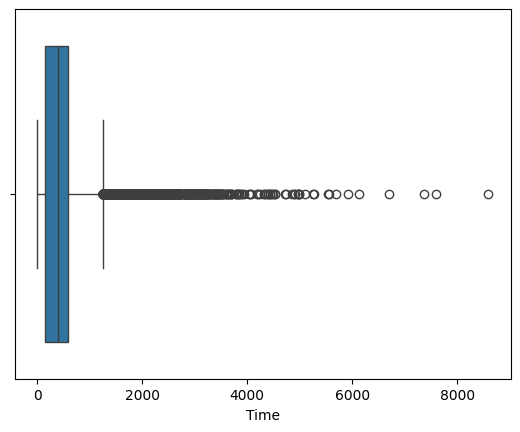

In [26]:
sns.boxplot(x=audible_data['Time'].dt.total_seconds() / 60)
plt.draw()

### Audiobook Ratings

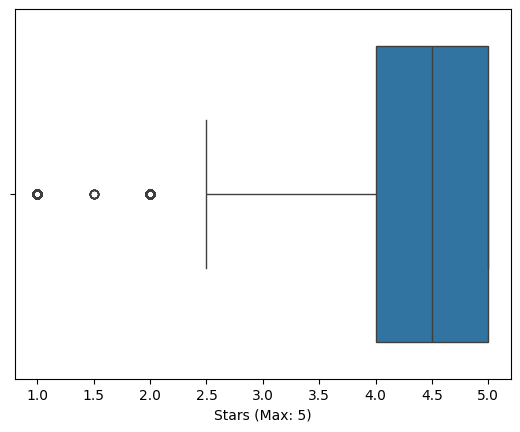

In [27]:
rated_audible_data = audible_data[audible_data['Rated'] == True]
sns.boxplot(x=rated_audible_data['Stars (Max: 5)'])
plt.draw()

### Audiobook Prices

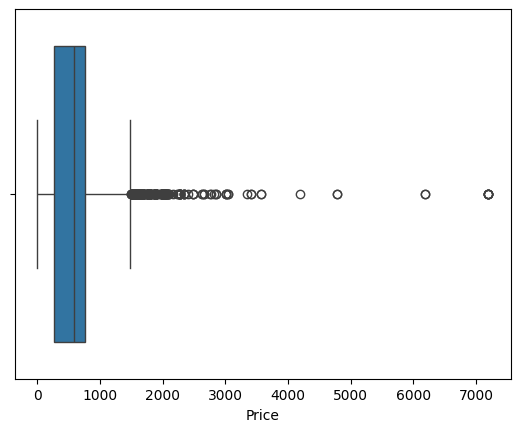

In [28]:
sns.boxplot(x=audible_data['Price'])
plt.draw()

### Conclusion

* The dataset consists of 87489 entries and 10 features, with 15072 entries rated and 72417 not.  
* The plot for Audiobook Lengths is skewed right, having most audiobooks under 1000 minutes. Several outliers indicate that some audiobooks are longer than the rest.  
* The plot for Audiobook Ratings is heavily skewed left with few outliers.  
* The plot for Audiobook Prices is skewed right, having most audiobook prices under 1000. Several outliers indicate that some audiobook prices fall into the range of 2000 to 4000, with a few higher than 4000.

## Audiobook Lengths vs. Ratings

Null Hypothesis: There is no correlation between the length of audiobooks and their ratings.  
Alternative Hypothesis: There is a correlation between the length of audiobooks and their ratings.

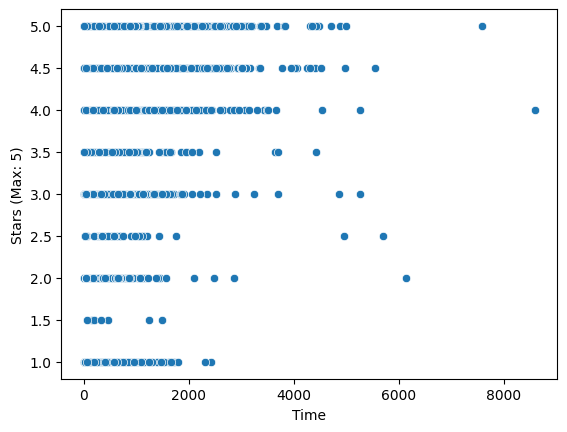

In [29]:
time_in_minutes = rated_audible_data['Time'].dt.total_seconds() / 60
sns.scatterplot(x=time_in_minutes, y=rated_audible_data['Stars (Max: 5)'])
plt.draw()

### T Test

In [30]:
time_in_minutes_median = time_in_minutes.median()
_, p_value = ttest_ind(
    rated_audible_data[time_in_minutes < time_in_minutes_median]['Stars (Max: 5)'],
    rated_audible_data[time_in_minutes >= time_in_minutes_median]['Stars (Max: 5)'],
    equal_var=False
)
p_value

0.06414265721241272

### Conclusion

Suppose the significance level (alpha) is 0.05, and the p-value is 0.0641, which is greater than alpha.  
Therefore, we fail to reject the null hypothesis. That is, there is no correlation between the length of audiobooks and their ratings.

## Audiobook Ratings vs. Prices

Null Hypothesis: There is no correlation between the rating of audiobooks and their prices.  
Alternative Hypothesis: There is a correlation between the rating of audiobooks and their prices.

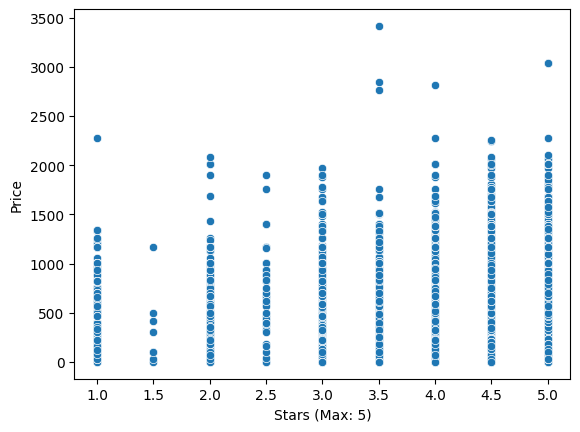

In [31]:
sns.scatterplot(x=rated_audible_data['Stars (Max: 5)'], y=rated_audible_data['Price'])
plt.draw()

### T Test

In [32]:
rating_mean = rated_audible_data['Stars (Max: 5)'].mean()
_, p_value = ttest_ind(
    rated_audible_data[rated_audible_data['Stars (Max: 5)'] < rating_mean]['Price'],
    rated_audible_data[rated_audible_data['Stars (Max: 5)'] >= rating_mean]['Price'],
    equal_var=False
)
p_value

0.00012565631566774675

### Conclusion

Suppose the significance level (alpha) is 0.05, and the p-value is 0.000126, which is less than alpha.  
Therefore, we reject the null hypothesis. That is, there is a correlation between the rating of audiobooks and their prices.